In [1]:
import numpy as np
from glob import glob
import torch
import os, sys, time, csv
import re
import random
import matplotlib.pyplot as plt
from PIL import Image
import ipywidgets as ipyw
import inspect
import pickle
%matplotlib inline

# Process image stacks into feature vector matrices using pre-trained model (for LSTM input).

In [2]:
# Torch imports.
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
import torchvision.models.resnet

# Visualization imports
from IPython import display


In [3]:
# Part A: Load in model pre-trained on individual images. Note that pre-training may not even be necessary, as I was only
# changing the weights on the last (new) fully connected layer, and that layer will likely be gotten rid of. 
model = models.densenet121(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
del model.classifier

# Assemble image pathnames and understand class breakdown in dataset

In [58]:
# Note down train, validation and test directories.
# topDir = 'Split_Data2'
# topDir = 'Split_Data_CIFAR1'
topDir = 'Split_Data2_Bam1_CIFAR_combined'

train_dir = topDir + "/train"
valid_dir = topDir + "/valid"
test_dir = topDir + "/test"
# test_dir = 'Bam1-CIFAR'

# Check quantities of train, validation and test images
train_images = np.array(glob(train_dir + "/*/*"))
valid_images = np.array(glob(valid_dir + "/*/*"))
test_images = np.array(glob(test_dir + "/*/*"))

# Check relative percentages of image types
train_images_absent = np.array(glob(train_dir + "/Absent/*"))
train_images_present = np.array(glob(train_dir + "/Present/*"))

valid_images_absent = np.array(glob(valid_dir + "/Absent/*"))
valid_images_present = np.array(glob(valid_dir + "/Present/*"))

test_images_absent = np.array(glob(test_dir + "/Absent/*"))
test_images_present = np.array(glob(test_dir + "/Present/*"))

num_train_images = len(train_images)
num_valid_images = len(valid_images)
num_test_images = len(test_images)

print("There are {} training stacks, {} validation stacks and {} test stacks.".format(len(train_images),len(valid_images),len(test_images)))
print("For the training stacks, {pos:=.1f}% ({pos2}) are positive and {neg:=.1f}% ({neg2}) are negative.".format(pos=len(train_images_present)/len(train_images)*100, pos2=len(train_images_present),neg=len(train_images_absent)/len(train_images)*100, neg2=len(train_images_absent)))
print("For the validation stacks, {pos:=.1f}% ({pos2}) are positive and {neg:=.1f}% ({neg2}) are negative.".format(pos=len(valid_images_present)/len(valid_images)*100, pos2=len(valid_images_present),neg=len(valid_images_absent)/len(valid_images)*100, neg2=len(valid_images_absent)))
print("For the test stacks, {pos:=.1f}% ({pos2}) are positive and {neg:=.1f}% ({neg2}) are negative.".format(pos=len(test_images_present)/len(test_images)*100, pos2=len(test_images_present),neg=len(test_images_absent)/len(test_images)*100, neg2=len(test_images_absent)))

There are 9768 training stacks, 1222 validation stacks and 1222 test stacks.
For the training stacks, 50.2% (4904) are positive and 49.8% (4864) are negative.
For the validation stacks, 50.2% (614) are positive and 49.8% (608) are negative.
For the test stacks, 50.2% (614) are positive and 49.8% (608) are negative.


In [59]:
# Check for GPU support
use_cuda = torch.cuda.is_available()

In [60]:
# Check to see how many GPUs are available.
device = torch.device("cuda" if use_cuda else "cpu")
if use_cuda:
    num_devices = torch.cuda.device_count()
    print("{} GPUs found.".format(num_devices))
else:
    num_devices = 0

1 GPUs found.


# Imports for torch and DALI functions

In [61]:
import torch.nn.functional as F

# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(224, 224, 3)
#         self.conv2 = nn.Conv2d(224, 224, 64) #2 layers
#         # http://web.media.mit.edu/~pratiks/combined-classification/convolutional-neural-network-for-combined-classification-of-fluorescent-biomarkers-and-expert-annotations-using-white-light-images.pdf
#         # https://www.pyimagesearch.com/2017/03/20/imagenet-vggnet-resnet-inception-xception-keras/
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, 16 * 5 * 5)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x


# net = Net()

In [62]:
# Define the model
class MM_DNN(nn.Module):
    def __init__(self, drop_prob=0.2, lr=0.001):
        super().__init__()
        self.drop_prob = drop_prob
        self.lr = lr
        
        self.dropout = nn.Dropout(drop_prob)
        
        self.fc = nn.Linear(4*1024,256)
        self.fc2 = nn.Linear(256,64)
        self.fc3 = nn.Linear(64,2)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hidden`. '''
        x = x.view(-1)
        out = self.dropout(self.relu(self.fc(x)))
        out = self.dropout(self.relu(self.fc2(out)))
        out = self.fc3(out)
        # return the final output
        return out
    


In [63]:
# Use the PyTorch data loader here, way easier. 
def load_pickle(path):
    with open(path,'rb') as f:
        return pickle.load(f)

In [64]:
train_data = datasets.DatasetFolder(train_dir,load_pickle,'.pickle')
validation_data = datasets.DatasetFolder(valid_dir,load_pickle,'.pickle')
test_data = datasets.DatasetFolder(test_dir,load_pickle,'.pickle')
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 1, shuffle=True, drop_last=True, num_workers=num_devices*4, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(validation_data, batch_size = 1, num_workers=num_devices*4, pin_memory=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 1, num_workers=num_devices*4, pin_memory=True)

In [65]:
x = load_pickle('/home/ubuntu/src/YPB-AI/Split_Data2/valid/Absent/XS_Negative_Dark_14-Mar-2019_18-53-16.pickle')
x.shape
# image, label = iter(train_loader).next()
# x

torch.Size([12, 1, 3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 32, 32)


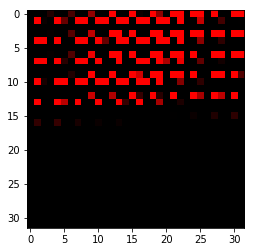

tensor([0])


In [38]:
def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()[0]
    print(npimg.shape)
    plt.imshow(np.transpose(npimg,(1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
print(labels)
# print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [66]:
saveName = 'Testing_Bam_all_CIFAR'

In [71]:
def train(net, train_loader, epochs=10, batch_size=2, lr=0.001, print_every=10):
    ''' Training a network 
    
        Arguments
        ---------
        
        net: DNN network
        train_loader: PyTorch dataloader containing data to train the network
        epochs: Number of epochs to train
        batch_size: Number of mini-sequences per mini-batch, aka batch size
        lr: learning rate
        print_every: Number of steps for printing training and validation loss
    
    '''
    valid_batch = 1
    net.train()
    
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    if(use_cuda):
        net.cuda()
    all_valid_losses = [.6]
    counter = 0
    for e in range(epochs):
        
        for batch_idx, batch_data in enumerate(train_loader):
            inputs = batch_data[0].view(12,batch_size,1024)
            inputs = inputs[0:4]
            targets = batch_data[1]
            if(use_cuda):
                inputs, targets = inputs.cuda(), targets.cuda()
            # zero accumulated gradients
            net.zero_grad()
            # get the output from the model
            output = net(inputs)
            # calculate the loss and perform backprop
            loss = criterion(output.view(batch_size,2), targets)
            loss.backward()
            opt.step()
            # loss stats
            if batch_idx % print_every == 0:
                # Get validation loss
                val_losses = []
                net.eval()
                correct = 0.
                total = 0.
                for val_batch_idx, batch_data in enumerate(valid_loader):                    
                    inputs, targets = batch_data[0].view(12,valid_batch,1024), batch_data[1]
                    inputs = inputs[0:4]
                    
                    if(use_cuda):
                        inputs, targets = inputs.cuda(), targets.cuda()

                    output = net(inputs)
                    val_loss = criterion(output.view(valid_batch,2), targets)
                    val_losses.append(val_loss.item())
                    pred = output.max(0,keepdim=True)[1]
                    # compare predictions to true label
                    correct += np.sum(np.squeeze(pred.eq(targets.data.view_as(pred))).cpu().numpy())
                    total += valid_batch
                
                net.train() # reset to train mode after iteration through validation data
                
                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(batch_idx),
                      "Loss: {:.4f}...".format(loss.item()),
                      "Val Loss: {:.4f}...".format(np.mean(val_losses)),
                      "Val Accuracy: {:.1f}%".format(correct/total*100))
                
                if np.mean(val_losses) < np.min(all_valid_losses):
                    print("Validation loss dropped, saving model.")
                    torch.save(net,'DNNModel_' + saveName + '.pt')
                    all_valid_losses = np.append(all_valid_losses,np.mean(val_losses))

In [ ]:
train(net,train_loader,50,1,print_every=6000,lr=0.0001)

In [67]:
import torch.nn as nn
import torch.nn.functional as F

# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html 
class CIFARNet1(nn.Module):
    def __init__(self):
        super(CIFARNet1, self).__init__()
        self.conv1 = nn.Conv2d(12, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = CIFARNet1()

In [68]:
# define and print the net

# net = MM_DNN()
net = CIFARNet1()
print(net)

CIFARNet1(
  (conv1): Conv2d(12, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)


In [69]:
epochs=50
batch_size=1
lr=0.0001
print_every=6000
valid_batch = 1
net.train()

opt = torch.optim.Adam(net.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

if(use_cuda):
    net.cuda()
all_valid_losses = [.6]
counter = 0
for e in range(epochs):

    for batch_idx, batch_data in enumerate(train_loader):
        # print(batch_data[0][0].shape)
        # inputs = batch_data[0][0].view(12,batch_size,3,32,32)
        inputs = batch_data[0][0]
        inputs = inputs[0:4]
        # print(inputs.shape)
        inputs = inputs.view(batch_size,12,32,32)
        targets = batch_data[1]
        if(use_cuda):
            inputs, targets = inputs.cuda(), targets.cuda()
        # zero accumulated gradients
        net.zero_grad()
        # get the output from the model
        output = net(inputs)
        # calculate the loss and perform backprop
        loss = criterion(output.view(batch_size,2), targets)
        loss.backward()
        opt.step()
        # loss stats
        if batch_idx % print_every == 0:
            # Get validation loss
            val_losses = []
            net.eval()
            correct = 0.
            total = 0.
            for val_batch_idx, batch_data in enumerate(valid_loader): 
                # inputs, targets = batch_data[0].view(12,valid_batch,1024), batch_data[1]
                inputs, targets = batch_data[0][0], batch_data[1]
                inputs = inputs[0:4]
                inputs = inputs.view(batch_size,12,32,32)

                if(use_cuda):
                    inputs, targets = inputs.cuda(), targets.cuda()

                output = net(inputs)
                # print(output)
                
                val_loss = criterion(output.view(valid_batch,2), targets)
                val_losses.append(val_loss.item())
                pred = output[0].max(0,keepdim=True)[1]
                # print(pred)
                # sm = nn.Softmax(dim=1)
                # sm_outputs = sm(output)
                # print(sm_outputs)
                # compare predictions to true label
                correct += np.sum(np.squeeze(pred.eq(targets.data.view_as(pred))).cpu().numpy())
                total += valid_batch

            net.train() # reset to train mode after iteration through validation data

            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(batch_idx),
                  "Loss: {:.4f}...".format(loss.item()),
                  "Val Loss: {:.4f}...".format(np.mean(val_losses)),
                  "Val Accuracy: {:.1f}%".format(correct/total*100))

            if np.mean(val_losses) < np.min(all_valid_losses):
                print("Validation loss dropped, saving model.")
                torch.save(net,'DNNModel_' + saveName + '.pt')
                # https://stackoverflow.com/questions/52277083/pytorch-saving-model-userwarning-couldnt-retrieve-source-code-for-container-of
                all_valid_losses = np.append(all_valid_losses,np.mean(val_losses))

Epoch: 1/50... Step: 0... Loss: 0.7693... Val Loss: 0.6971... Val Accuracy: 49.8%
Epoch: 1/50... Step: 6000... Loss: 0.4350... Val Loss: 0.5442... Val Accuracy: 72.3%
Validation loss dropped, saving model.


/home/ubuntu/anaconda3/envs/derm-ai/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type CIFARNet1. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 2/50... Step: 0... Loss: 0.0164... Val Loss: 0.4689... Val Accuracy: 80.9%
Validation loss dropped, saving model.
Epoch: 2/50... Step: 6000... Loss: 0.6204... Val Loss: 0.3822... Val Accuracy: 84.6%
Validation loss dropped, saving model.
Epoch: 3/50... Step: 0... Loss: 0.0552... Val Loss: 0.3406... Val Accuracy: 88.4%
Validation loss dropped, saving model.
Epoch: 3/50... Step: 6000... Loss: 0.0433... Val Loss: 0.2694... Val Accuracy: 90.1%
Validation loss dropped, saving model.
Epoch: 4/50... Step: 0... Loss: 0.0834... Val Loss: 0.2589... Val Accuracy: 89.9%
Validation loss dropped, saving model.
Epoch: 4/50... Step: 6000... Loss: 0.8473... Val Loss: 0.2046... Val Accuracy: 93.0%
Validation loss dropped, saving model.
Epoch: 5/50... Step: 0... Loss: 0.0000... Val Loss: 0.2532... Val Accuracy: 89.2%
Epoch: 5/50... Step: 6000... Loss: 0.4414... Val Loss: 0.2163... Val Accuracy: 92.8%
Epoch: 6/50... Step: 0... Loss: 0.3227... Val Loss: 0.1826... Val Accuracy: 94.7%
Validation loss 

Epoch: 48/50... Step: 0... Loss: 0.0000... Val Loss: 0.1619... Val Accuracy: 96.0%
Epoch: 48/50... Step: 6000... Loss: 0.0000... Val Loss: 0.1873... Val Accuracy: 95.6%
Epoch: 49/50... Step: 0... Loss: 0.0066... Val Loss: 0.1330... Val Accuracy: 96.2%
Epoch: 49/50... Step: 6000... Loss: 0.0000... Val Loss: 0.1510... Val Accuracy: 96.1%
Epoch: 50/50... Step: 0... Loss: 0.0000... Val Loss: 0.1242... Val Accuracy: 96.0%
Epoch: 50/50... Step: 6000... Loss: 0.0000... Val Loss: 0.1475... Val Accuracy: 95.7%


## Test on test data

In [19]:
saveName = 'Testing_CIFAR'

In [51]:
net = CIFARNet1()
print(net)

CIFARNet1(
  (conv1): Conv2d(12, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)


In [70]:
net = torch.load('DNNModel_' + saveName + '.pt')
stateDictName ='DNN_StateDict_' + saveName + '.pt'

In [71]:
torch.save(net.state_dict(), stateDictName)

In [72]:
net.load_state_dict(torch.load(stateDictName))

In [23]:
# Test with all data
test_dir = 'Training2'
test_data = datasets.DatasetFolder(test_dir,load_pickle,'.pickle')
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 1, shuffle=True, drop_last=True, num_workers=num_devices*4, pin_memory=True)

In [83]:
test_loader.dataset.samples[test_batch][0]

'Split_Data2_Bam1_CIFAR_combined/test/Absent/6S_Negative_Dark_14-Mar-2019_10-01-29.pickle'

In [85]:
# Test CIFAR
net.eval()
correct = 0.
total = 0.
false_pos = 0.
false_neg = 0.
test_batch = 1
test_losses = []
batch_size = 1
criterion = nn.CrossEntropyLoss()

false_pos_img = []
false_neg_img = []

for test_batch_idx, batch_data in enumerate(test_loader):                    
    inputs, targets = batch_data[0][0], batch_data[1]
    inputs = inputs[0:4]
    inputs = inputs.view(batch_size,12,32,32)

    if(use_cuda):
        inputs, targets = inputs.cuda(), targets.cuda()

    # print(inputs)
    output = net(inputs)

    test_loss = criterion(output.view(test_batch,2), targets)
    test_losses.append(test_loss.item()/len(test_loader))

    pred = output[0].max(0,keepdim=True)[1]
    
    # compare predictions to true label
    correct += np.sum(np.squeeze(pred.eq(targets.data.view_as(pred))).cpu().numpy())
    
    # number of false positives; hack for batch size = 1
    # false_pos += int(targets.data.cpu().numpy()[0] == 0 and pred.data.cpu().numpy()[0] == 1)
    if targets.data.cpu().numpy()[0] == 0 and pred.data.cpu().numpy()[0] == 1:
        false_pos += 1
        false_pos_img.append(test_loader.dataset.samples[test_batch_idx][0])
    
    # number of false negatives; hack for batch size = 1
    # false_neg += int(targets.data.cpu().numpy()[0] == 1 and pred.data.cpu().numpy()[0] == 0)
    if targets.data.cpu().numpy()[0] == 1 and pred.data.cpu().numpy()[0] == 0:
        false_neg += 1
        false_neg_img.append(test_loader.dataset.samples[test_batch_idx][0])
    
    total += test_batch

In [87]:
print(correct)
print(total)
print(false_pos)
print(false_neg)
int(targets.data.cpu().numpy()[0] == 1 and pred.data.cpu().numpy()[0] == 0)

1172.0
1222.0
10.0
40.0


0

Split_Data2_Bam1_CIFAR_combined/test/Present/6S_Sample3_Light_27-Mar-2019_13-08-17.pickle
Training_images/6S_Sample3_Light/ProtectCodeScannerResults_27-Mar-2019_13-08-17/Photos


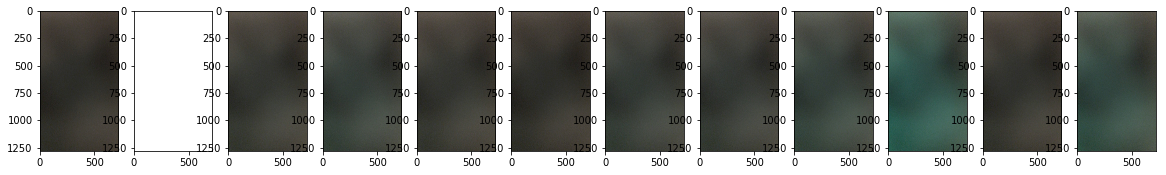

Split_Data2_Bam1_CIFAR_combined/test/Present/6S_filledBottle_V_30-Oct-2019_11-17-07.pickle
30_10_62_original/6S_filledBottle_V/ProtectCodeScannerResults_30-Oct-2019_11-17-07/Photos


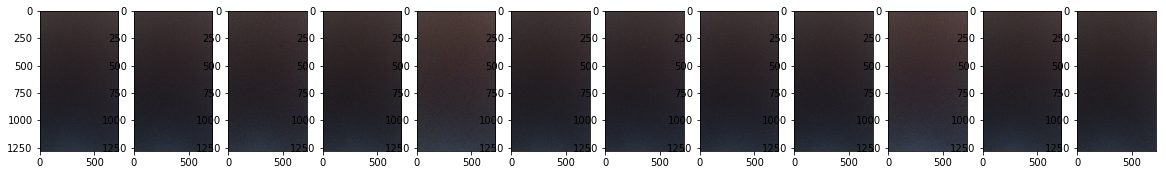

Split_Data2_Bam1_CIFAR_combined/test/Present/6S_filledBottle_V_30-Oct-2019_11-22-42.pickle
30_10_62_original/6S_filledBottle_V/ProtectCodeScannerResults_30-Oct-2019_11-22-42/Photos


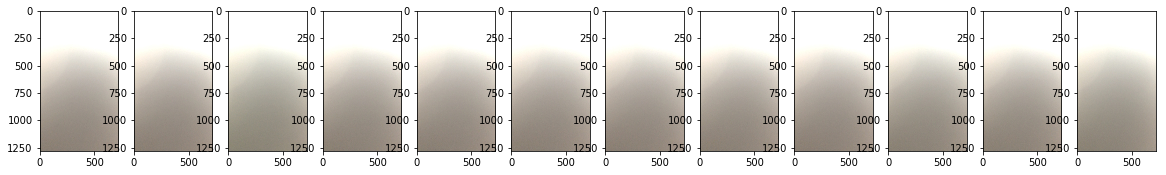

Split_Data2_Bam1_CIFAR_combined/test/Present/6S_filledBottle_V_30-Oct-2019_11-25-41.pickle
30_10_62_original/6S_filledBottle_V/ProtectCodeScannerResults_30-Oct-2019_11-25-41/Photos


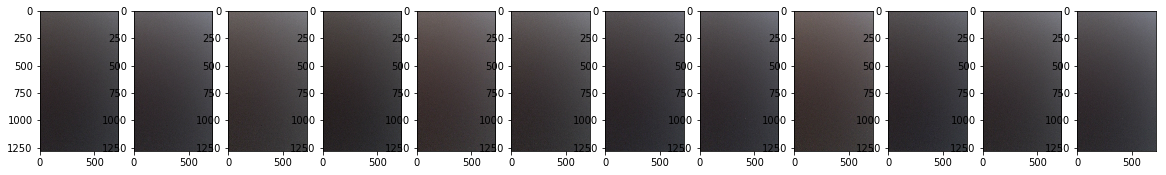

Split_Data2_Bam1_CIFAR_combined/test/Present/6S_filledBottle_V_30-Oct-2019_11-29-31.pickle
30_10_62_original/6S_filledBottle_V/ProtectCodeScannerResults_30-Oct-2019_11-29-31/Photos


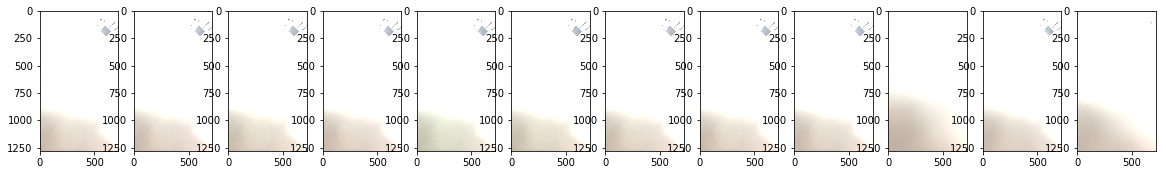

Split_Data2_Bam1_CIFAR_combined/test/Present/6S_filledBottle_V_30-Oct-2019_11-37-44.pickle
30_10_62_original/6S_filledBottle_V/ProtectCodeScannerResults_30-Oct-2019_11-37-44/Photos


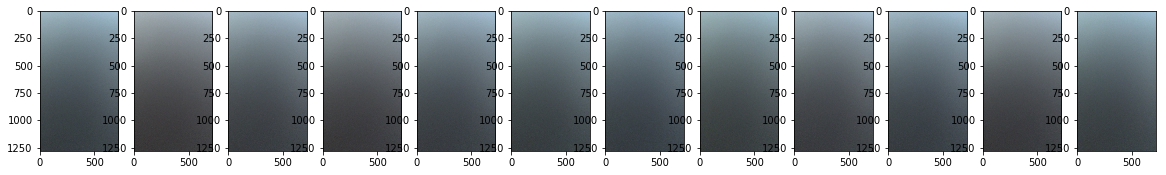

Split_Data2_Bam1_CIFAR_combined/test/Present/6S_redBottle_H_29-Oct-2019_10-28-04.pickle
29_10_62_original/6S_redBottle_H/ProtectCodeScannerResults_29-Oct-2019_10-28-04/Photos


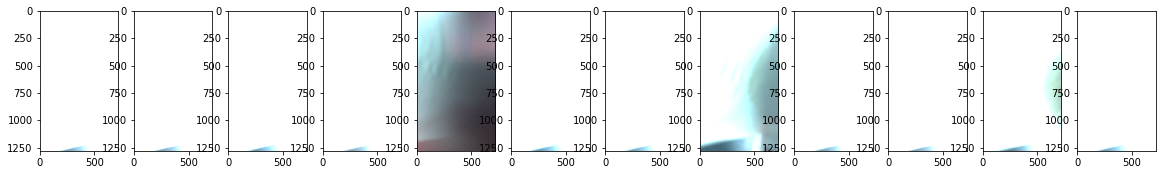

Split_Data2_Bam1_CIFAR_combined/test/Present/6S_redBottle_V_30-Oct-2019_08-36-23.pickle
30_10_62_original/6S_redBottle_V/ProtectCodeScannerResults_30-Oct-2019_08-36-23/Photos


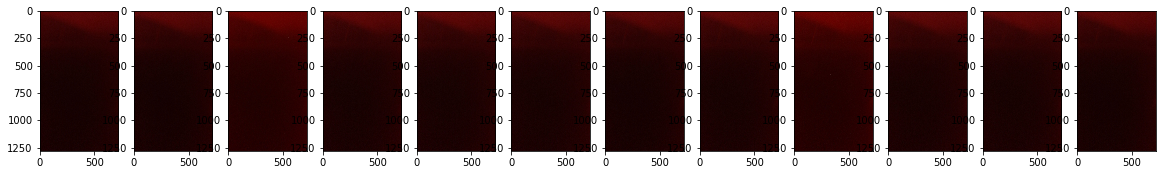

Split_Data2_Bam1_CIFAR_combined/test/Present/6_Sample2_Dark_08-Mar-2019_17-16-46.pickle
Training_images/6_Sample2_Dark/ProtectCodeScannerResults_08-Mar-2019_17-16-46/Photos


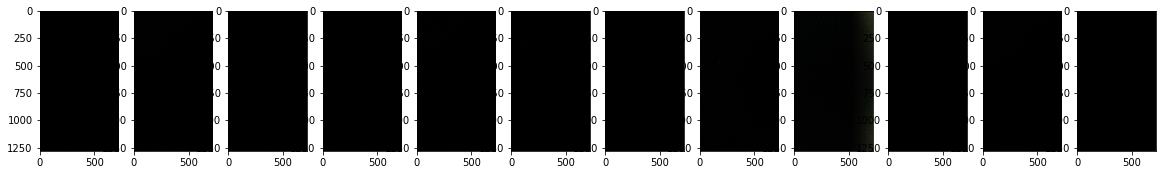

Split_Data2_Bam1_CIFAR_combined/test/Present/6_Sample3_Light_25-Mar-2019_14-43-12.pickle
Training_images/6_Sample3_Light/ProtectCodeScannerResults_25-Mar-2019_14-43-12/Photos
error
Split_Data2_Bam1_CIFAR_combined/test/Present/6_Sample3_Light_25-Mar-2019_15-06-36.pickle
Training_images/6_Sample3_Light/ProtectCodeScannerResults_25-Mar-2019_15-06-36/Photos
error
Split_Data2_Bam1_CIFAR_combined/test/Present/6_Sample3_Light_25-Mar-2019_15-23-19.pickle
Training_images/6_Sample3_Light/ProtectCodeScannerResults_25-Mar-2019_15-23-19/Photos
error
Split_Data2_Bam1_CIFAR_combined/test/Present/6_Sample3_Light_25-Mar-2019_15-40-10.pickle
Training_images/6_Sample3_Light/ProtectCodeScannerResults_25-Mar-2019_15-40-10/Photos
error
Split_Data2_Bam1_CIFAR_combined/test/Present/7_Sample2_Dark_12-Mar-2019_13-33-15.pickle
Training_images/7_Sample2_Dark/ProtectCodeScannerResults_12-Mar-2019_13-33-15/Photos


<Figure size 1440x2880 with 0 Axes>

<Figure size 1440x2880 with 0 Axes>

<Figure size 1440x2880 with 0 Axes>

<Figure size 1440x2880 with 0 Axes>

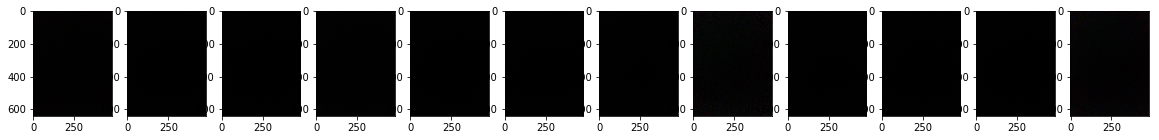

Split_Data2_Bam1_CIFAR_combined/test/Present/7_Sample3_Light_27-Mar-2019_14-27-04.pickle
Training_images/7_Sample3_Light/ProtectCodeScannerResults_27-Mar-2019_14-27-04/Photos


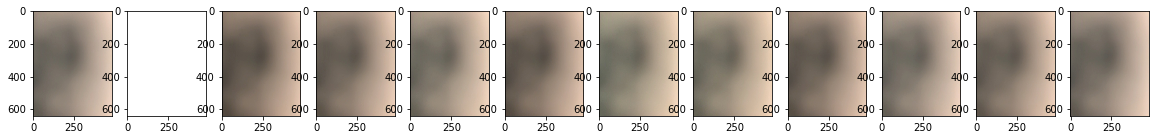

Split_Data2_Bam1_CIFAR_combined/test/Present/7_Sample3_Light_27-Mar-2019_14-27-20.pickle
Training_images/7_Sample3_Light/ProtectCodeScannerResults_27-Mar-2019_14-27-20/Photos


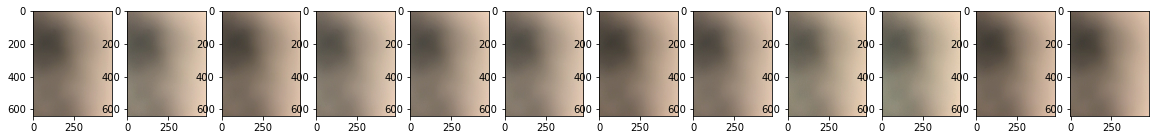

Split_Data2_Bam1_CIFAR_combined/test/Present/7_Sample4_Dark_12-Mar-2019_12-18-10.pickle
Training_images/7_Sample4_Dark/ProtectCodeScannerResults_12-Mar-2019_12-18-10/Photos


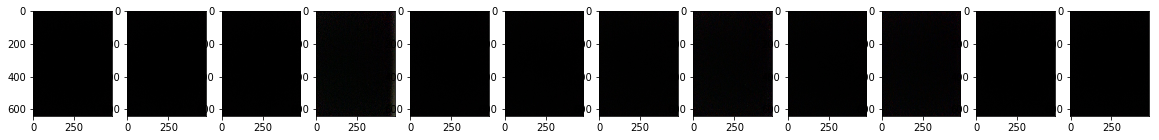

Split_Data2_Bam1_CIFAR_combined/test/Present/7_Sample5_Dark_12-Mar-2019_11-38-44.pickle
Training_images/7_Sample5_Dark/ProtectCodeScannerResults_12-Mar-2019_11-38-44/Photos


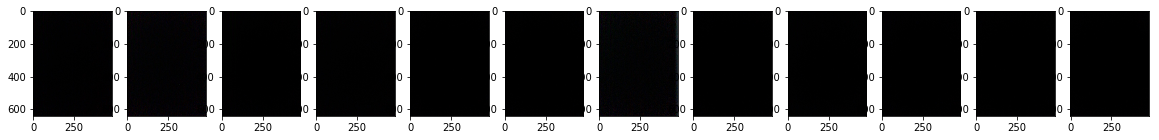

Split_Data2_Bam1_CIFAR_combined/test/Present/7_Sample5_Dark_12-Mar-2019_11-44-47.pickle
Training_images/7_Sample5_Dark/ProtectCodeScannerResults_12-Mar-2019_11-44-47/Photos


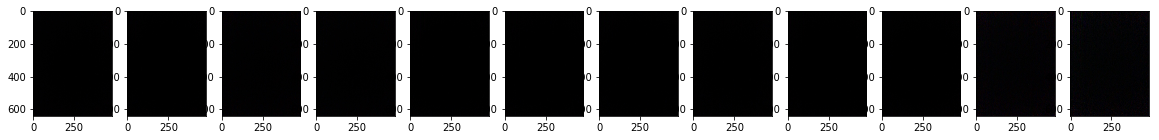

Split_Data2_Bam1_CIFAR_combined/test/Present/7_Sample5_Light_27-Mar-2019_15-21-19.pickle
Training_images/7_Sample5_Light/ProtectCodeScannerResults_27-Mar-2019_15-21-19/Photos


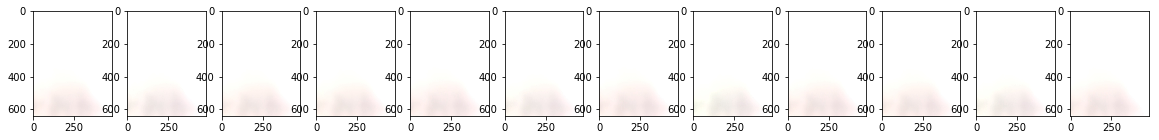

Split_Data2_Bam1_CIFAR_combined/test/Present/SE_Sample3_Light_28-Mar-2019_15-40-42.pickle
Training_images/SE_Sample3_Light/ProtectCodeScannerResults_28-Mar-2019_15-40-42/Photos


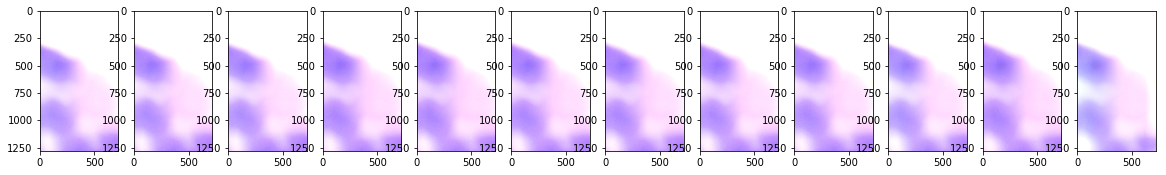

Split_Data2_Bam1_CIFAR_combined/test/Present/SE_Sample3_Light_28-Mar-2019_15-50-04.pickle
Training_images/SE_Sample3_Light/ProtectCodeScannerResults_28-Mar-2019_15-50-04/Photos


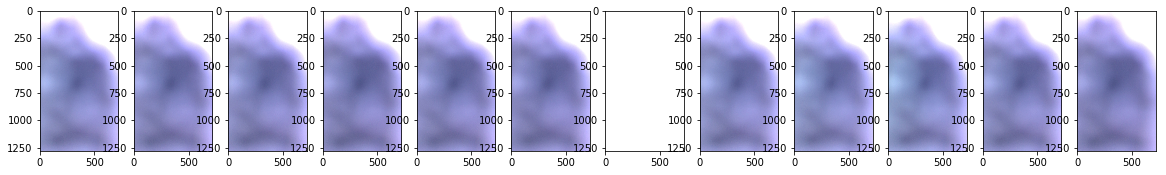

Split_Data2_Bam1_CIFAR_combined/test/Present/SE_Sample5_Dark_11-Mar-2019_14-38-33.pickle
Training_images/SE_Sample5_Dark/ProtectCodeScannerResults_11-Mar-2019_14-38-33/Photos


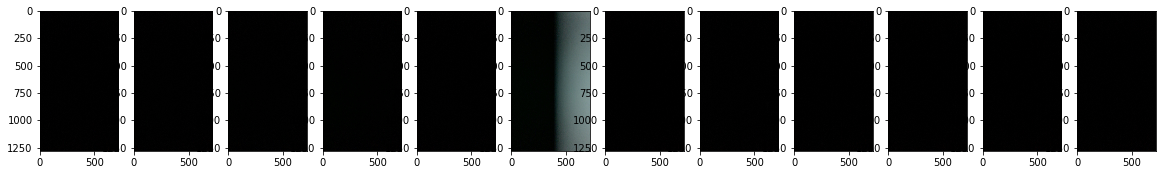

Split_Data2_Bam1_CIFAR_combined/test/Present/XS_Sample1_Dark_12-Mar-2019_15-17-08.pickle
Training_images/XS_Sample1_Dark/ProtectCodeScannerResults_12-Mar-2019_15-17-08/Photos


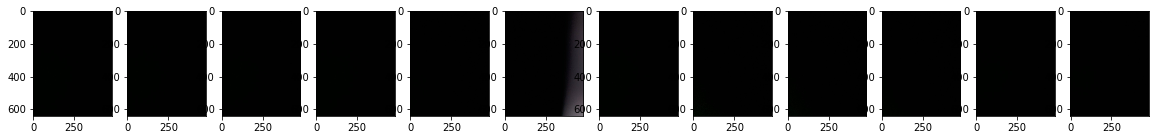

Split_Data2_Bam1_CIFAR_combined/test/Present/XS_Sample1_Dark_12-Mar-2019_15-21-59.pickle
Training_images/XS_Sample1_Dark/ProtectCodeScannerResults_12-Mar-2019_15-21-59/Photos


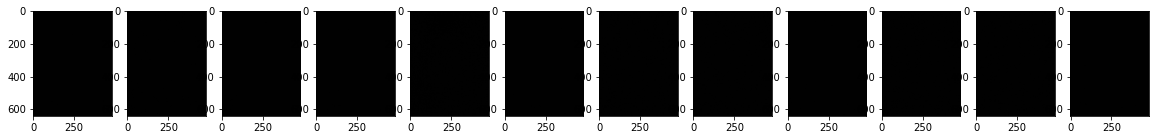

Split_Data2_Bam1_CIFAR_combined/test/Present/XS_Sample2_Dark_12-Mar-2019_16-02-13.pickle
Training_images/XS_Sample2_Dark/ProtectCodeScannerResults_12-Mar-2019_16-02-13/Photos


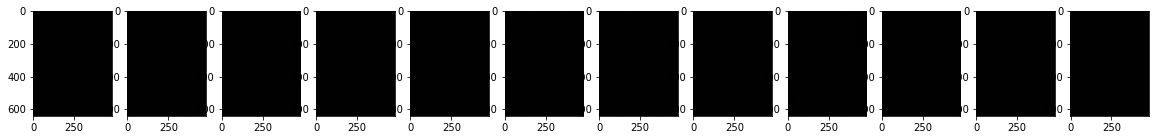

Split_Data2_Bam1_CIFAR_combined/test/Present/XS_Sample2_Dark_12-Mar-2019_16-03-19.pickle
Training_images/XS_Sample2_Dark/ProtectCodeScannerResults_12-Mar-2019_16-03-19/Photos


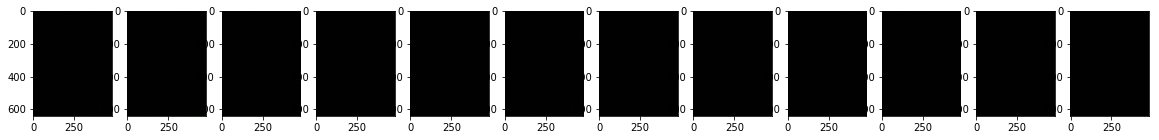

Split_Data2_Bam1_CIFAR_combined/test/Present/XS_Sample3_Light_28-Mar-2019_14-22-27.pickle
Training_images/XS_Sample3_Light/ProtectCodeScannerResults_28-Mar-2019_14-22-27/Photos


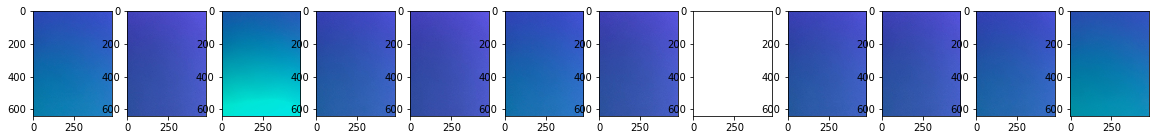

Split_Data2_Bam1_CIFAR_combined/test/Present/XS_Sample4_Dark_12-Mar-2019_16-52-29.pickle
Training_images/XS_Sample4_Dark/ProtectCodeScannerResults_12-Mar-2019_16-52-29/Photos
error
Split_Data2_Bam1_CIFAR_combined/test/Present/XS_Sample4_Dark_12-Mar-2019_16-54-53.pickle
Training_images/XS_Sample4_Dark/ProtectCodeScannerResults_12-Mar-2019_16-54-53/Photos
error
Split_Data2_Bam1_CIFAR_combined/test/Present/XS_Sample4_Dark_12-Mar-2019_17-03-49.pickle
Training_images/XS_Sample4_Dark/ProtectCodeScannerResults_12-Mar-2019_17-03-49/Photos
error
Split_Data2_Bam1_CIFAR_combined/test/Present/XS_Sample4_Dark_12-Mar-2019_17-05-35.pickle
Training_images/XS_Sample4_Dark/ProtectCodeScannerResults_12-Mar-2019_17-05-35/Photos
error
Split_Data2_Bam1_CIFAR_combined/test/Present/XS_Sample4_Dark_12-Mar-2019_17-06-23.pickle
Training_images/XS_Sample4_Dark/ProtectCodeScannerResults_12-Mar-2019_17-06-23/Photos
error
Split_Data2_Bam1_CIFAR_combined/test/Present/XS_Sample4_Dark_12-Mar-2019_17-06-49.pickle
Traini

<Figure size 1440x2880 with 0 Axes>

<Figure size 1440x2880 with 0 Axes>

<Figure size 1440x2880 with 0 Axes>

<Figure size 1440x2880 with 0 Axes>

<Figure size 1440x2880 with 0 Axes>

<Figure size 1440x2880 with 0 Axes>

<Figure size 1440x2880 with 0 Axes>

<Figure size 1440x2880 with 0 Axes>

<Figure size 1440x2880 with 0 Axes>

<Figure size 1440x2880 with 0 Axes>

<Figure size 1440x2880 with 0 Axes>

<Figure size 1440x2880 with 0 Axes>

In [88]:
# View images that are false negatives
# print(false_neg_img)

top_folder = 'Training_images/'
basewidth = 100

for pickle_file in false_neg_img:
    print(pickle_file)
    if '30-Oct-2019' in pickle_file:
        top_folder = '30_10_62_original/'
    elif '29-Oct-2019' in pickle_file:
        top_folder = '29_10_62_original/'
    else: 
        top_folder = 'Training_images/'
    folder_and_file_name = pickle_file.split('/')[3]
    delimiter_bits = re.split("\w*_", folder_and_file_name) # my failed attempt to properly use regular expressions
    folder = folder_and_file_name.split(delimiter_bits[1])[0][:-1]
    datetime = delimiter_bits[1] + '2019_' + delimiter_bits[2].split('.pickle')[0]
    img_folder = top_folder + folder + '/ProtectCodeScannerResults_' + datetime + '/Photos'
    print(img_folder)
    try: 
        idx = 1
        plt.figure(figsize=(20,40))
        for img_file in os.listdir(img_folder):
            if img_file.endswith(".JPG"): 
                # print(img_folder + '/' + img_file)
                img = Image.open(img_folder + '/' + img_file)
                # wpercent = (basewidth/float(img.size[0]))
                # hsize = int((float(img.size[1])*float(wpercent)))
                # img = img.resize((basewidth,hsize), Image.ANTIALIAS)
                plt.subplot(1, 12, idx)
                plt.imshow(img)
                idx += 1
        plt.show()
    except:
        print('error')
        continue

Split_Data2_Bam1_CIFAR_combined/test/Absent/6S_Negative_Random_03-Jun-2019_14-13-21.pickle
Training_images/6S_Negative_Random/ProtectCodeScannerResults_03-Jun-2019_14-13-21/Photos


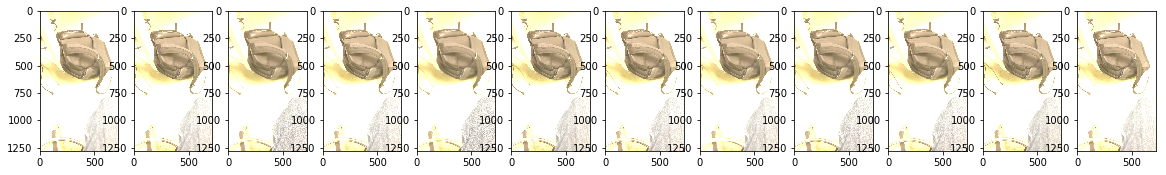

Split_Data2_Bam1_CIFAR_combined/test/Absent/6S_Negative_Random_03-Jun-2019_14-50-09.pickle
Training_images/6S_Negative_Random/ProtectCodeScannerResults_03-Jun-2019_14-50-09/Photos


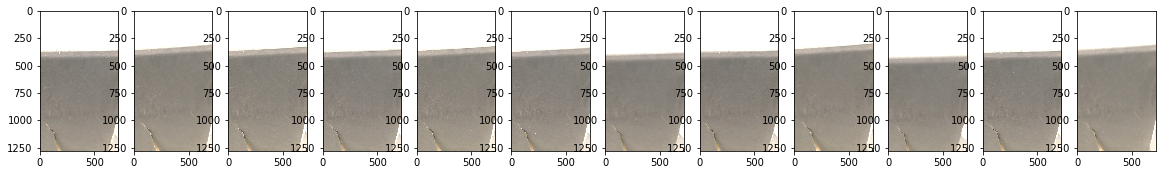

Split_Data2_Bam1_CIFAR_combined/test/Absent/6S_filledBottle_V_Negative_30-Oct-2019_17-46-35.pickle
30_10_62_original/6S_filledBottle_V_Negative/ProtectCodeScannerResults_30-Oct-2019_17-46-35/Photos


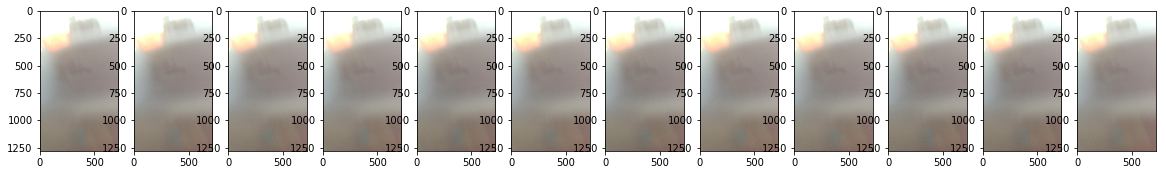

Split_Data2_Bam1_CIFAR_combined/test/Absent/6S_redBottle_H_Negative_29-Oct-2019_16-32-33.pickle
29_10_62_original/6S_redBottle_H_Negative/ProtectCodeScannerResults_29-Oct-2019_16-32-33/Photos


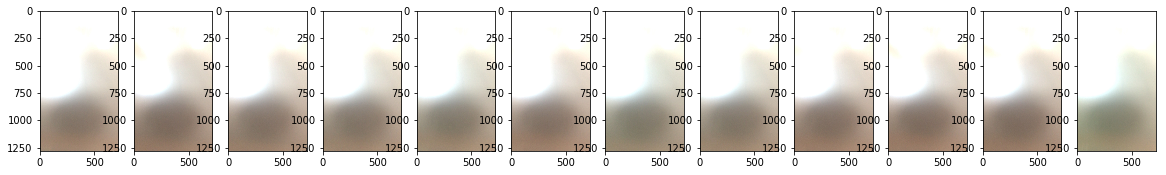

Split_Data2_Bam1_CIFAR_combined/test/Absent/6_Negative_Sample3_Back_Light_16-Apr-2019_13-38-23.pickle
Training_images/6_Negative_Sample3_Back_Light/ProtectCodeScannerResults_16-Apr-2019_13-38-23/Photos


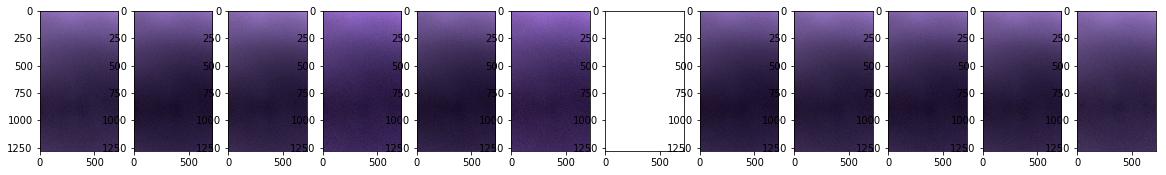

Split_Data2_Bam1_CIFAR_combined/test/Absent/7_Negative_Random_30-May-2019_17-03-50.pickle
Training_images/7_Negative_Random/ProtectCodeScannerResults_30-May-2019_17-03-50/Photos


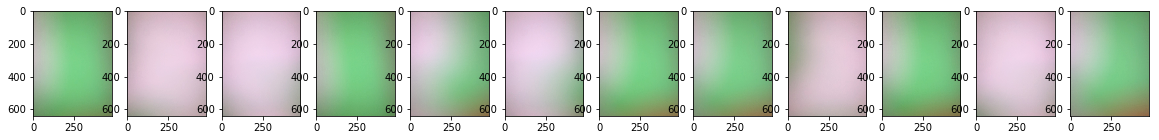

Split_Data2_Bam1_CIFAR_combined/test/Absent/7_Negative_Random_30-May-2019_17-05-30.pickle
Training_images/7_Negative_Random/ProtectCodeScannerResults_30-May-2019_17-05-30/Photos


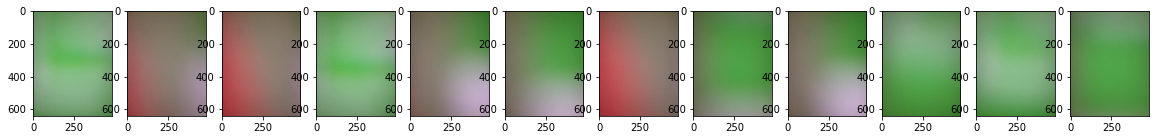

Split_Data2_Bam1_CIFAR_combined/test/Absent/7_Negative_Random_30-May-2019_17-18-08.pickle
Training_images/7_Negative_Random/ProtectCodeScannerResults_30-May-2019_17-18-08/Photos


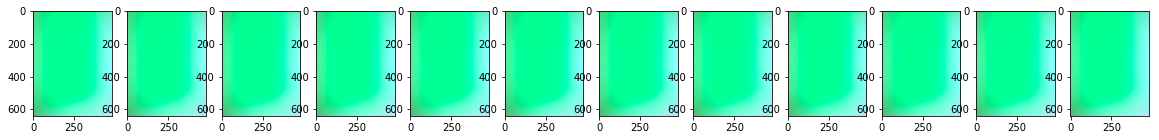

Split_Data2_Bam1_CIFAR_combined/test/Absent/7_Negative_Random_30-May-2019_17-22-11.pickle
Training_images/7_Negative_Random/ProtectCodeScannerResults_30-May-2019_17-22-11/Photos


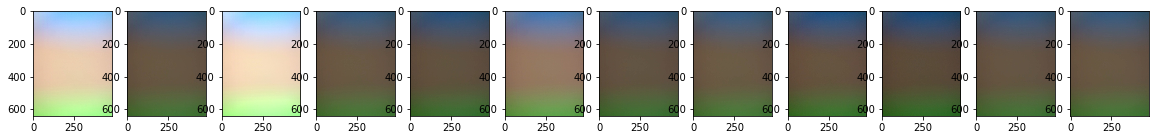

Split_Data2_Bam1_CIFAR_combined/test/Absent/XS_Negative_Random_30-May-2019_16-04-57.pickle
Training_images/XS_Negative_Random/ProtectCodeScannerResults_30-May-2019_16-04-57/Photos
error


<Figure size 1440x2880 with 0 Axes>

In [89]:
# View false positives
# print(false_pos_img)

# basewidth = 100

for pickle_file in false_pos_img:
    print(pickle_file)
    if '30-Oct-2019' in pickle_file:
        top_folder = '30_10_62_original/'
    elif '29-Oct-2019' in pickle_file:
        top_folder = '29_10_62_original/'
    else: 
        top_folder = 'Training_images/'
    folder_and_file_name = pickle_file.split('/')[3]
    delimiter_bits = re.split("\w*_", folder_and_file_name) # my failed attempt to properly use regular expressions
    folder = folder_and_file_name.split(delimiter_bits[1])[0][:-1]
    datetime = delimiter_bits[1] + '2019_' + delimiter_bits[2].split('.pickle')[0]
    img_folder = top_folder + folder + '/ProtectCodeScannerResults_' + datetime + '/Photos'
    print(img_folder)
    try: 
        idx = 1
        plt.figure(figsize=(20,40))
        for img_file in os.listdir(img_folder):
            if img_file.endswith(".JPG"): 
                # print(img_folder + '/' + img_file)
                img = Image.open(img_folder + '/' + img_file)
                # wpercent = (basewidth/float(img.size[0]))
                # hsize = int((float(img.size[1])*float(wpercent)))
                # img = img.resize((basewidth,hsize), Image.ANTIALIAS)
                plt.subplot(1, 12, idx)
                plt.imshow(img)
                idx += 1
        plt.show()
    except:
        print('error')
        continue

## Test MM_DNN (Baseline)

In [42]:
saveName = 'Testing'

In [43]:
net = MM_DNN()
print(net)

MM_DNN(
  (dropout): Dropout(p=0.2)
  (fc): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
)


In [44]:
net = torch.load('DNNModel_' + saveName + '.pt')
stateDictName ='DNN_StateDict_' + saveName + '.pt'

In [45]:
# Test with all data
test_dir = 'Training'
test_data = datasets.DatasetFolder(test_dir,load_pickle,'.pickle')
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 1, shuffle=True, drop_last=True, num_workers=num_devices*4, pin_memory=True)

In [46]:
net.eval()
correct = 0.
total = 0.
false_pos = 0.
false_neg = 0.
test_batch = 1
test_losses = []
criterion = nn.CrossEntropyLoss()
for test_batch_idx, batch_data in enumerate(test_loader):                    
    inputs, targets = batch_data[0].view(12,test_batch,1024), batch_data[1]
    inputs = inputs[0:4]

    if(use_cuda):
        inputs, targets = inputs.cuda(), targets.cuda()

    # print(inputs)
    output = net(inputs)

    test_loss = criterion(output.view(test_batch,2), targets)
    test_losses.append(test_loss.item()/len(test_loader))

    pred = output.max(0,keepdim=True)[1]
    
    # compare predictions to true label
    correct += np.sum(np.squeeze(pred.eq(targets.data.view_as(pred))).cpu().numpy())
    
    # number of false positives; hack for batch size = 1
    false_pos += int(targets.data.cpu().numpy()[0] == 0 and pred.data.cpu().numpy()[0] == 1)
    
    # number of false negatives; hack for batch size = 1
    false_neg += int(targets.data.cpu().numpy()[0] == 1 and pred.data.cpu().numpy()[0] == 0)
    
    total += test_batch

In [47]:
# MM_DNN
print(correct)
print(total)
print(false_pos)
print(false_neg)
int(targets.data.cpu().numpy()[0] == 1 and pred.data.cpu().numpy()[0] == 0)

11269.0
11405.0
88.0
48.0


0

In [37]:
net = torch.load('DNNModel_' + saveName + '.pt')
stateDictName ='DNN_StateDict_' + saveName + '.pt'

In [38]:
torch.save(net.state_dict(), stateDictName)

In [39]:
net.load_state_dict(torch.load(stateDictName))

In [40]:
net.load_state_dict(torch.load('DNN_StateDict_S3_Iter_1.pt'))

# Zip up state dict, get over to S3

In [90]:
# The below lines are only needed if allowing SageMaker to perform inference on the model.
# I can walk you through that when you get there.

#tarName = 'DNNModel_' + saveName + '.tar.gz' 

In [91]:
#os.system('tar -cvzf ' + tarName + ' ' + stateDictName)
#os.system('aws s3 cp ' + tarName + ' s3://ypb-ml-images/' + tarName)

0